In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [5]:
stock_data = pd.read_csv('source\dfnew_clean.csv')
stock_data["FutureOne"]= stock_data.Close.shift(-1)
stock_data["FutureThree"]= stock_data.Close.shift(-3)
stock_data["FutureFive"]= stock_data.Close.shift(-5)
stock_data.dropna()

,DateTime,Volume,Transaction,Open,High,Low,Close,Dir,Change,ForeignBuy,ForeignSell,ForeignNet,TrustBuy,TrustSell,TrustNet,DealerNet,DealerBuy,DealerSell,InvestorsNet,PE-Ratio,PBR,Yield,ForeignVol,TrustVol,DealerVol,InvestorsVol,Pattern,Trend,InvestorsNet_Dir,ForeignNet_Dir,TrustNet_Dir,DealerNet_Dir,Dir2,FutureOne,FutureThree,FutureFive
0,2013-01-02,40647,14353,97.6,99.9,97.1,99.6,+,2.6,22484,8625,13859,1746,147,1599,-350,1300,1650,15108,16.54,3.83,3.01,31109,1893,2950,35952,0,0,1,1,1,0,0,101.0,100.5,100.0
1,2013-01-03,44335,12616,100.5,102.0,100.0,101.0,+,1.4,32303,17347,14955,926,516,410,-1067,1512,2579,14298,16.78,3.88,2.97,49651,1442,4091,55184,0,0,1,1,1,0,1,101.5,99.7,101.0
2,2013-01-04,39502,10276,100.5,101.5,100.0,101.5,+,0.5,33581,24337,9244,234,190,44,-246,910,1156,9042,16.86,3.90,2.96,57919,424,2066,60409,0,0,1,1,1,0,1,100.5,100.0,101.0
3,2013-01-07,42328,9042,101.0,101.0,99.1,100.5,-,1.0,26613,26952,-339,203,925,-722,-450,871,1321,-1511,16.69,3.86,2.99,53565,1128,2192,56885,0,0,0,0,0,0,2,99.7,101.0,102.0
4,2013-01-08,31218,9463,99.6,100.0,98.9,99.7,-,0.8,16628,15087,1540,209,635,-426,-80,749,829,1034,16.56,3.83,3.01,31715,844,1578,34137,0,0,1,1,0,0,2,100.0,101.0,100.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2022-12-19,24231,30247,466.5,469.5,465.0,466.5,-,4.5,14328,17346,-3017,565,206,359,-1075,212,1287,-3733,13.64,4.42,2.36,31674,771,1499,33944,0,0,0,0,1,0,2,457.5,468.0,456.5
2443,2022-12-20,33181,59543,465.0,467.0,455.0,457.5,-,9.0,11840,19861,-8021,655,21,633,-1251,341,1592,-8638,13.38,4.33,2.40,31701,676,1933,34310,0,0,0,0,1,0,2,459.0,455.0,457.0
2444,2022-12-21,40831,31581,460.0,463.0,457.0,459.0,+,1.5,32181,31770,410,578,991,-413,-1033,465,1498,-1035,13.42,4.35,2.40,63951,1569,1963,67484,6,0,0,1,0,0,1,468.0,456.5,451.0
2445,2022-12-22,14519,16893,466.5,469.0,464.0,468.0,+,9.0,8931,5839,3091,576,2,574,-286,214,501,3378,13.68,4.43,2.35,14771,578,715,16064,0,2,1,1,1,0,1,455.0,457.0,446.0


In [6]:
target = ['FutureOne']
features = ['Transaction','Open', 'High', 'Low','Change','TrustNet','InvestorsNet','Close']
df = stock_data[features + target]

In [7]:
# split the data
split = int(df.shape[0] * 0.8)
df_train = df.iloc[:split, :].copy()
df_test = df.iloc[split:, :].copy()

# scale the data
target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features])
df_train[features] = features_scaler.transform(df_train[features])
df_test[features] = features_scaler.transform(df_test[features])

# extract the input sequences and output values
sequence_length = 5

X_train, y_train = [], []

for i in range(sequence_length, df_train.shape[0]):
    X_train.append(df_train[features + target].iloc[i - sequence_length: i])
    y_train.append(df_train[target].iloc[i])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []

for i in range(sequence_length, df_test.shape[0]):
    X_test.append(df_test[features + target].iloc[i - sequence_length: i])
    y_test.append(df_test[target].iloc[i])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape)
print(X_test.shape)

(1956, 5, 9)
(486, 5, 9)


In [8]:
# build and train the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
# model.add(LSTM(units=200, activation="tanh", return_sequences=False))
# model.add(Dropout(0.2))
# model.add(LSTM(units=20, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=60, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=120, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(units=50))
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             12000     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 73,421
Trainable params: 73,421
Non-traina

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')

train_history=model.fit(X_train, y_train, epochs=50, batch_size=64)

model.evaluate(X_test, y_test)

#save the model
model.save('save\LSTM_eps50_bsize64.h5')

# generate the test set predictions
y_pred = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred)

Epoch 1/50
31/31 [==============================] - 2s 7ms/step - loss: 0.0296
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0013
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 9.6179e-04
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 6/50
31/31 [==============================] - 0s 7ms/step - loss: 9.3311e-04
Epoch 7/50
31/31 [==============================] - 0s 7ms/step - loss: 8.6783e-04
Epoch 8/50
31/31 [==============================] - 0s 7ms/step - loss: 8.8208e-04
Epoch 9/50
31/31 [==============================] - 0s 7ms/step - loss: 8.2766e-04
Epoch 10/50
31/31 [==============================] - 0s 7ms/step - loss: 8.9531e-04
Epoch 11/50
31/31 [==============================] - 0s 7ms/step - loss: 9.6167e-04
Epoch 12/50
31/31 [==============================] - 0s 7ms/step - loss: 8.1508e-04
Epoch 13/50
31/31

In [10]:
# plot the test set predictions
df['Predicted'] = np.nan
df['Predicted'].iloc[- y_pred.shape[0]:] = y_pred.flatten()
# plot=df[['Close', 'Predicted Close']].plot()
# fig = plot.get_figure()
# fig.savefig("multi_intput_LSTM_model_eps32_bsize64.png")
res=pd.concat([stock_data['DateTime'],df],axis=1)
dfpred=res[['DateTime','Open','Close', 'Predicted']].dropna()
dfpred

,DateTime,Open,Close,Predicted
1966,2021-01-08,580.0,580.0,549.078613
1967,2021-01-11,577.0,584.0,559.337585
1968,2021-01-12,583.0,591.0,566.631714
1969,2021-01-13,595.0,605.0,574.926514
1970,2021-01-14,587.0,592.0,581.457275
...,...,...,...,...
2447,2022-12-26,454.0,456.5,470.080780
2448,2022-12-27,458.0,457.0,468.521820
2449,2022-12-28,451.0,451.0,465.718872
2450,2022-12-29,444.0,446.0,460.966156


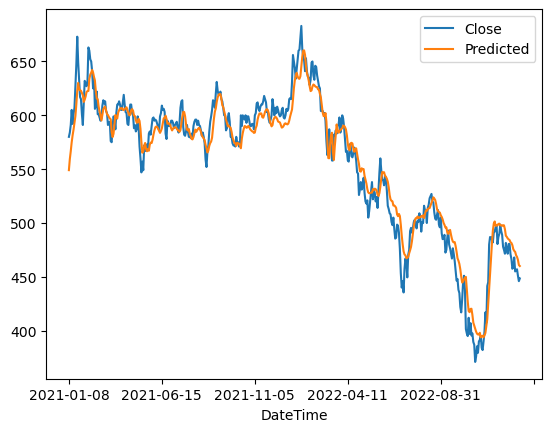

In [11]:
plot=dfpred.plot(x='DateTime',y=['Close','Predicted'])
fig = plot.get_figure()
fig.savefig("save\LSTM_eps32_bsize64.png")